In [17]:
import os
import sys
sys.path.insert(0, os.getcwd())

import tensorflow as tf
from keras.callbacks import EarlyStopping

import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# modify sys.path for it to contain the main repo path so we can import modules such as below
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from utils.helper import set_seed
from utils.data import load_data_with_test_split
from utils.plots import plot_reconstructions, plot_history
from utils.latent_space import plot_latent_space
from utils.evaluation import evaluate_autoencoder_with_threshold_generator
from utils.models import get_model

epoch/epoch,▁
epoch/learning_rate,▁
epoch/loss,▁
epoch/val_loss,▁
epoch/epoch,0
epoch/learning_rate,0.001
epoch/loss,0.1818
epoch/val_loss,0.22548


Found 256 images belonging to 1 classes.
Found 64 images belonging to 1 classes.
Found 98 images belonging to 6 classes.
Found 62 images belonging to 6 classes.


/Users/hendriksippel/Documents/Repositories/itu-aml-anomaly-detection/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.2283
Epoch 1: val_loss improved from inf to 0.22548, saving model to models/checkpoints/test kmeans.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step - loss: 0.2231 - val_loss: 0.2255
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - loss: 0.0918
Epoch 2: val_loss improved from 0.22548 to 0.17396, saving model to models/checkpoints/test kmeans.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 78s 10s/step - loss: 0.0907 - val_loss: 0.1740
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - loss: 0.0620
Epoch 3: val_loss improved from 0.17396 to 0.16384, saving model to models/checkpoints/test kmeans.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 9s/step - loss: 0.0616 - val_loss: 0.1638
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.0511
Epoch 4: val_loss improved from 0.16384 to 0.12548, saving model to models/checkpoints/test kmeans.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 62s 8s/step - loss: 0.0509 - val_loss: 0.1255
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - lo

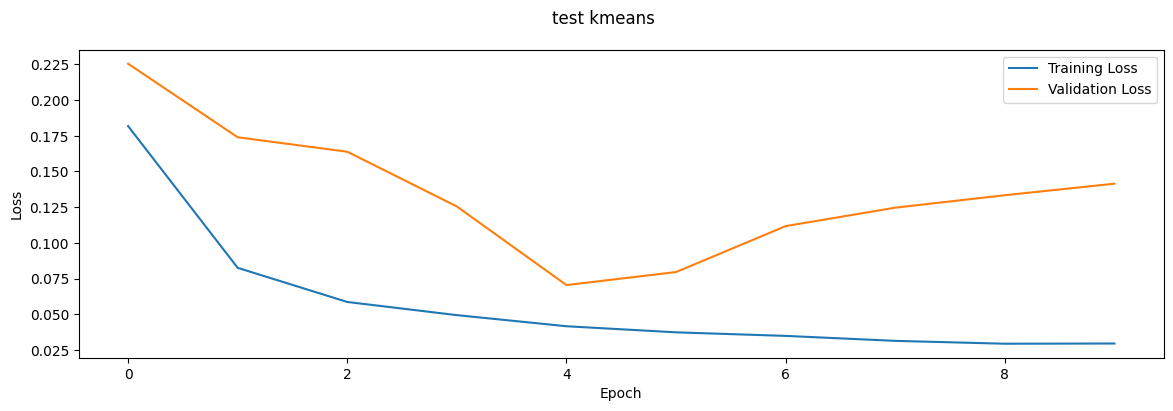

Best train_loss: 0.0294
Best val_loss: 0.0705
Last improvement of val_loss at epoch: 5
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


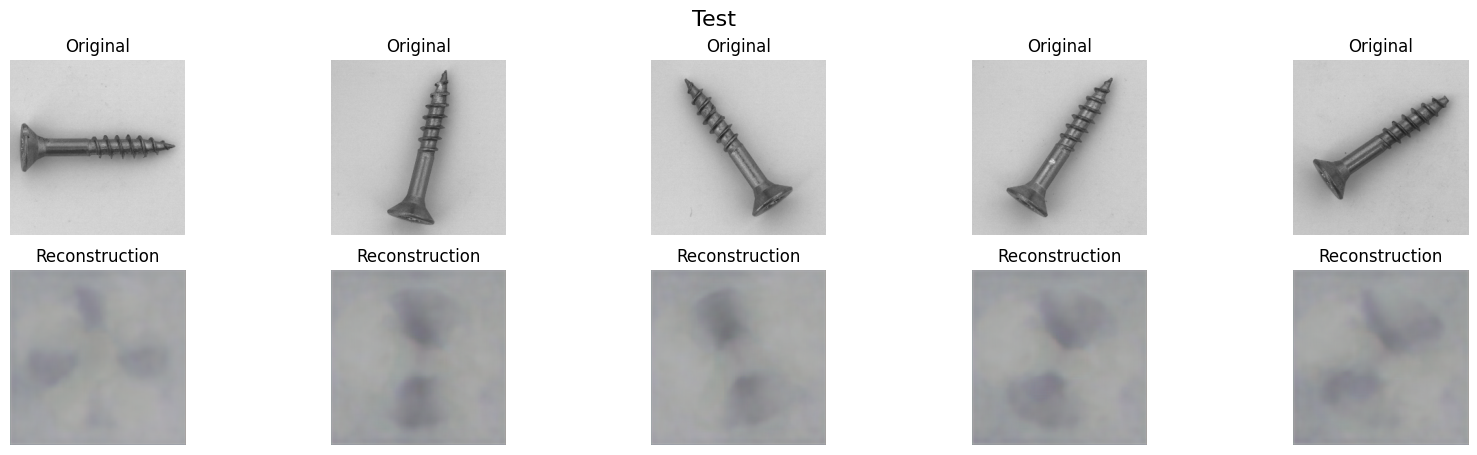

In [18]:
wandb_project = "ablation-study"
wandb_tags = [
    "autoencoder", 
    "test" # remove this tage when running the actual training
]

config = {
        "comment" : "test kmeans",
        "model_name" : "vanilla_autoencoder", # available options: "vanilla_autoencoder", "deep_autoencoder", ...
        # Taken as given
        "data_class" : "screw", # available options: "screw", "metal_nut" and more
        "epochs" : 10,
        "latent_dim" : 512,
        "optimizer" : 'adam',
        "batch_size" : 16,
        "rotation_range" : 90,
        # Hyperparameters
        "batch_norm" : True,
        "dropout_value" : 0.2, # setting this value to 0 will basically remove dropout layers
        "loss" : 'mae', # available options: 'mse', 'mae', 'ssim'
        }

set_seed(42)

wandb.init(project=wandb_project, tags=wandb_tags, config=config)
wandb.define_metric('val_loss', summary='min')
config = wandb.config

# Load data
train_generator, validation_generator, test_generator, threshold_generator = load_data_with_test_split(
    category=config.data_class,
    batch_size=32,
    test_split=0.4,
    rotation_range=config.rotation_range
    )

# Build model
autoencoder = get_model(config)

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', mode='min', patience=20),
    WandbMetricsLogger(),
    WandbModelCheckpoint(filepath=f"models/checkpoints/{config.comment}.keras", verbose=1, save_best_only=True)
]

# Train model
history = autoencoder.fit(
    train_generator,
    epochs=config.epochs,
    validation_data=validation_generator,
    callbacks=callbacks
)

# Plot results
plot_history(comment=config.comment, history=history, wandb=wandb)
plot_reconstructions(autoencoder, test_generator, n_images=5, title='Test', wandb=wandb)

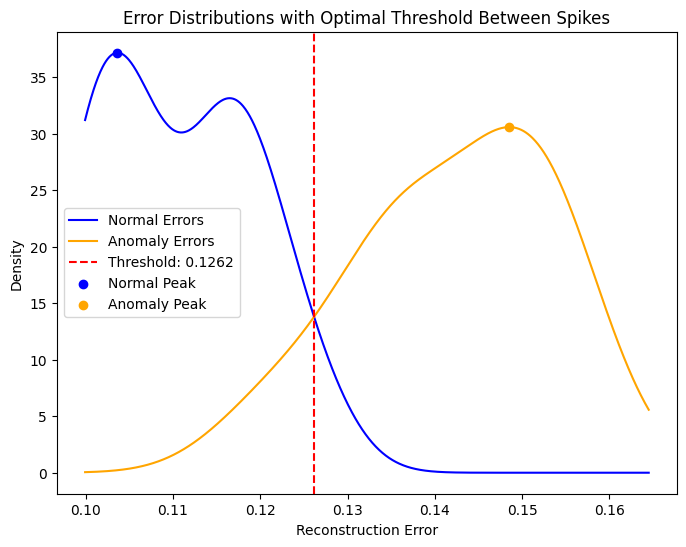

Optimal Threshold: 0.1262


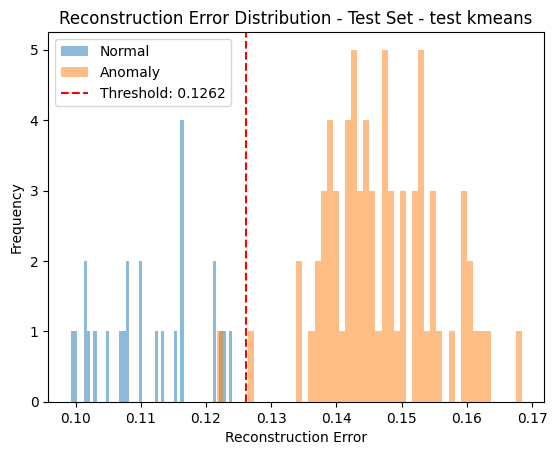

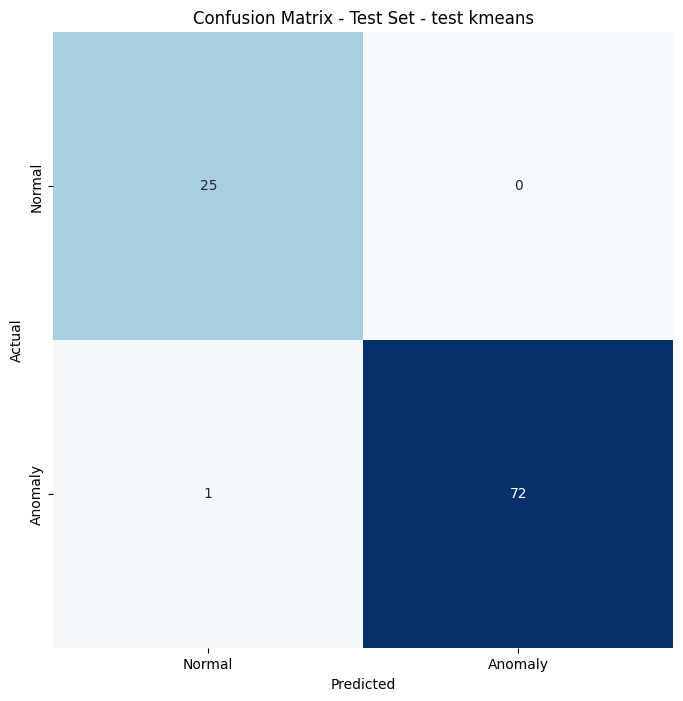

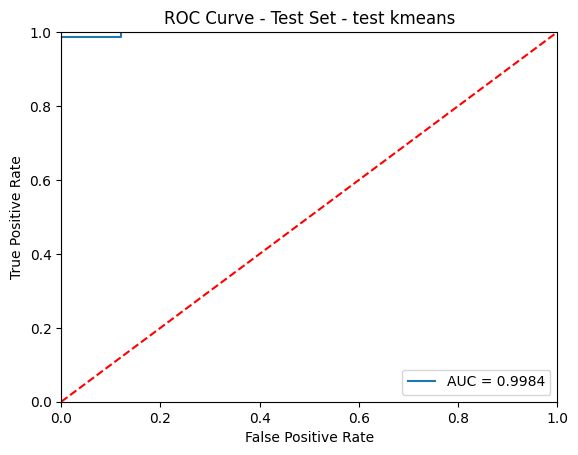

In [21]:
evaluate_autoencoder_with_threshold_generator(autoencoder, test_generator, threshold_generator, config=config, wandb=wandb)

In [19]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report

def get_latents_and_labels(autoencoder: Model, generator):
    """
    Extract latent vectors (from the bottleneck layer) for each image in `generator`,
    and gather the corresponding labels (1=anomaly, 0=normal).

    Parameters:
    -----------
    autoencoder (Model): 
        The trained autoencoder model that has a layer named 'bottleneck'.
    generator (ImageDataGenerator): 
        The test data generator. Must have class_indices including "good".

    Returns:
    --------
    latents (np.ndarray):
        Latent vectors of shape (N, latent_dim) (or shape (N, H, W, C) if not flattened).
    labels (np.ndarray):
        Ground truth labels, with 1=anomaly and 0=normal, shape (N,).
    """
    # 1) Build an encoder model that outputs from the 'bottleneck' layer
    encoder = Model(
        inputs=autoencoder.input,
        outputs=autoencoder.get_layer('bottleneck').output
    )

    # 2) Identify which index corresponds to "good"
    relevant_label_index = generator.class_indices["good"]

    latents_list = []
    labels_list = []

    # 3) Iterate over all batches in the generator
    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        
        # 3A) Predict bottleneck features
        batch_latents = encoder.predict(batch_images, verbose=0)
        latents_list.append(batch_latents)
        
        # 3B) Extract the "good" label from batch_labels and invert to get anomaly label
        # If batch_labels[:, relevant_label_index] == 1 => "good" => anomaly=0
        # So we do anomaly_label = 1 - good_label
        batch_good_labels = batch_labels[:, relevant_label_index]       # shape (batch_size,)
        batch_anomaly_labels = [1 - lbl for lbl in batch_good_labels]   # 1 means anomaly, 0 means normal
        labels_list.extend(batch_anomaly_labels)

    # 4) Concatenate all batch latents
    latents = np.concatenate(latents_list, axis=0)
    labels = np.array(labels_list).astype(int)

    return latents, labels

def fit_kmeans_on_latents(latent_vectors, n_clusters=2, random_state=42):
    """
    Fit K-Means on latent vectors (embedding space).
    
    Parameters:
    -----------
    latent_vectors : np.ndarray
        Shape (N, embedding_dim).
    n_clusters : int
        How many clusters to find, e.g., 2 for normal vs anomaly.
    random_state : int
        For reproducibility.

    Returns:
    --------
    kmeans_model : KMeans
        The fitted KMeans model.
    """
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans_model.fit(latent_vectors)
    return kmeans_model

def classify_with_kmeans(kmeans_model, latent_vectors):
    """
    Assign cluster labels to new data based on the fitted K-Means model.
    
    Parameters:
    -----------
    kmeans_model : KMeans
        The already-trained K-Means model.
    latent_vectors : np.ndarray
        Embeddings for new data, shape (M, embedding_dim).
        
    Returns:
    --------
    labels : np.ndarray
        Cluster labels for each sample, in [0..n_clusters-1].
    """
    labels = kmeans_model.predict(latent_vectors)
    return labels

Mean error in Cluster 0: 0.0224
Mean error in Cluster 1: 0.0222


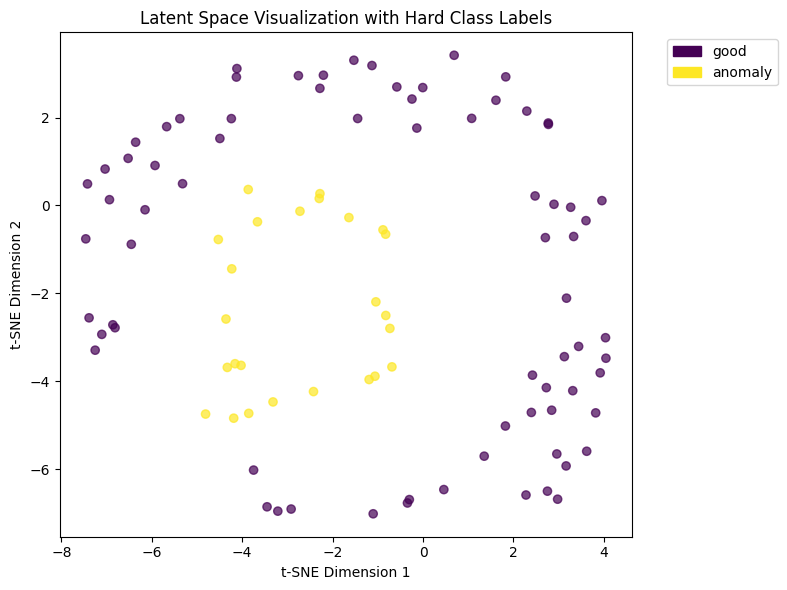

Confusion Matrix (0=Normal, 1=Anomaly):
[[15 13]
 [39 31]]
              precision    recall  f1-score   support

      Normal       0.28      0.54      0.37        28
     Anomaly       0.70      0.44      0.54        70

    accuracy                           0.47        98
   macro avg       0.49      0.49      0.45        98
weighted avg       0.58      0.47      0.49        98

Done with example pipeline.


In [20]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model
from utils.evaluation import calculate_error

def example_pipeline(autoencoder, test_generator):
    """
    Demonstration of how to:
      1) Extract latent vectors for test data (both normal & anomaly).
      2) Compute reconstruction errors for each image.
      3) Fit K-Means (k=2) in latent space.
      4) Assign clusters -> normal vs. anomaly based on mean reconstruction error.
      5) Optionally plot latent space with cluster assignments.
    """

    # ------------------------------------------------------------------
    # A) Get latents (N, latent_dim) and ground-truth labels (N,).
    #    We'll assume you have a function 'get_latents_and_labels' that:
    #      - extracts embeddings from your "bottleneck" layer
    #      - returns labels with 0=normal, 1=anomaly
    # ------------------------------------------------------------------
    latents, gt_labels = get_latents_and_labels(autoencoder, test_generator)

    # ------------------------------------------------------------------
    # B) Compute reconstruction errors for each image
    #    We'll re-run the generator to get images + compute AE error
    #    or just do it in the same loop if you prefer (depends on your code).
    # ------------------------------------------------------------------
    # Make sure to reset the generator if needed (test_generator.reset())
    # for a fresh iteration over all samples
    test_generator.reset()

    errors = []
    images_count = 0
    for _ in range(len(test_generator)):
        batch_images, _ = next(test_generator)
        # Reconstruct
        batch_recons = autoencoder.predict(batch_images, verbose=0)
        # Calculate error for each image
        batch_errs = calculate_error(batch_images, batch_recons, loss_function='mse')
        errors.extend(batch_errs)
        images_count += len(batch_errs)

    errors = np.array(errors)
    if len(errors) != len(latents):
        print(f"Warning: mismatch in lengths: latents={len(latents)}, errors={len(errors)}")
    
    # ------------------------------------------------------------------
    # C) Fit K-Means (2 clusters: normal vs anomaly) in latent space
    # ------------------------------------------------------------------
    kmeans_model = KMeans(n_clusters=2, random_state=42)
    kmeans_model.fit(latents)
    pred_clusters = kmeans_model.predict(latents)

    # Indices for cluster 0 and cluster 1
    cluster0_indices = np.where(pred_clusters == 0)[0]
    cluster1_indices = np.where(pred_clusters == 1)[0]

    # ------------------------------------------------------------------
    # D) Determine which cluster is "normal" vs. "anomaly" based on
    #    mean reconstruction error in each cluster
    # ------------------------------------------------------------------
    mean_error_cluster0 = np.mean(errors[cluster0_indices]) if len(cluster0_indices) > 0 else np.inf
    mean_error_cluster1 = np.mean(errors[cluster1_indices]) if len(cluster1_indices) > 0 else np.inf

    print(f"Mean error in Cluster 0: {mean_error_cluster0:.4f}")
    print(f"Mean error in Cluster 1: {mean_error_cluster1:.4f}")

    # If cluster0 has lower mean error, label it "normal" => 0, else 1
    if mean_error_cluster0 < mean_error_cluster1:
        # cluster 0 -> normal, cluster 1 -> anomaly
        cluster0_label = 0
        cluster1_label = 1
    else:
        # cluster 0 -> anomaly, cluster 1 -> normal
        cluster0_label = 1
        cluster1_label = 0

    # Build final predicted labels array
    pred_labels = np.zeros_like(pred_clusters)
    pred_labels[cluster0_indices] = cluster0_label
    pred_labels[cluster1_indices] = cluster1_label

    # ------------------------------------------------------------------
    # E) Plot latent space with cluster assignments
    #    (Assuming you have a function plot_latent_space)
    #    You can pass:
    #      - latents
    #      - ground truth labels (gt_labels)
    #      - cluster or predicted labels (pred_labels)
    # ------------------------------------------------------------------
    plot_latent_space(autoencoder, test_generator, wandb)

    # ------------------------------------------------------------------
    # F) Optionally evaluate how well your cluster-based classification
    #    matches ground truth
    # ------------------------------------------------------------------
    print("Confusion Matrix (0=Normal, 1=Anomaly):")
    cm = confusion_matrix(gt_labels, pred_labels)
    print(cm)
    print(classification_report(gt_labels, pred_labels, target_names=["Normal","Anomaly"]))

    print("Done with example pipeline.")

example_pipeline(autoencoder, test_generator)